In [1]:
# Data stuffs
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
from moxie.data.utils_ import load_data, standardize, de_standardize, normalize_profiles

# Plotting
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec

# Make it look pretty
from IPython.display import display, HTML
from tqdm.notebook import tqdm  

# ML Stuff
import torch 
from torch.nn import functional as F
from moxie.models.DIVA_ak_2 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK_1 import EXAMPLE_DIVA_EXP_AK
from moxie.models.utils_ import conditional_inference_simple_mean

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [2]:
# Load data 
train_data, val_data, test_data = load_data(dataset_choice='SANDBOX_NO_VARIATIONS', file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_1052022_elm_timings.pickle', elm_timings=True)
(train_X, train_y, train_mask, train_radii, train_real_space_radii, train_ids, train_uncert, train_elm_timings), (val_X, val_y, val_mask, val_radii, val_real_space_radii, val_ids, val_uncert, val_elm_timings), (test_X, test_y, test_mask, test_radii, test_real_space_radii, test_ids, test_uncert, test_elm_timings) = train_data, val_data, test_data

machine_param_order = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER']
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
FLAGS = [x for x in JET_PDB.columns.to_list() if 'FLAG' in x]

train_pulse_order = [int(x.split('/')[0]) for x in train_ids]
train_pulses = list(set(train_pulse_order))
train_pulse_idxs = [[index for index in range(len(train_pulse_order)) if train_pulse_order[index] == pulse] for pulse in train_pulses]

val_pulse_order = [int(x.split('/')[0]) for x in val_ids]
val_pulses = list(set(val_pulse_order))
val_pulse_idxs = [[index for index in range(len(val_pulse_order)) if val_pulse_order[index] == pulse] for pulse in val_pulses]

test_pulse_order = [int(x.split('/')[0]) for x in test_ids]
test_pulses = list(set(test_pulse_order))
test_pulse_idxs = [[index for index in range(len(test_pulse_order)) if test_pulse_order[index] == pulse] for pulse in test_pulses]


In [3]:
from scipy.stats import truncnorm


In [10]:

def calculate_nesep_for_pulse(both_profiles, both_uncertanties, integer_masks, pulse_rmids, lbound_n, ubound_n, lbound_t, ubound_t, conditional_prediction=False, local_pulse_number=None, check_SOL_radius=False):
    """
    This will return the neseps predicted for each time slice in the pulse. 
    """
    
    lbound_r, ubound_r, rad_var, SOL_width = 3.7, 3.9, 0.0055, 0.020
    
    pulse_neseps = np.zeros(len(both_profiles))
    pulse_teseps = np.zeros(len(both_profiles))
    pulse_teseps_masked = np.zeros(len(both_profiles))
    pulse_neseps_masked = np.zeros(len(both_profiles))
    pulse_rseps = np.zeros(len(both_profiles))
    
    if conditional_prediction: 
        integer_masks = np.ones_like(integer_masks, dtype=bool)
        both_uncertanties = np.ones_like(both_uncertanties, dtype=bool)*200
    for n, (both_profiles_slice, both_uncertanties_slice, mask_int_slice, slice_rmid) in enumerate(zip(both_profiles, both_uncertanties, integer_masks, pulse_rmids)):
        bool_mask = mask_int_slice > 0
        bool_mask = np.logical_and(bool_mask, both_uncertanties_slice[0, :] < 1e19)
        slice_ne, slice_te = both_profiles_slice[0, :][bool_mask], both_profiles_slice[1, :][bool_mask]
        slice_ne_uncert, slice_te_uncert = both_uncertanties_slice[0, :][bool_mask], both_uncertanties_slice[1, :][bool_mask]
        slice_rmid_mask = slice_rmid[bool_mask]
        
        # Get the SOL radius first
        radii_gaussians = np.array([np.linspace(truncnorm.ppf(0.01, (lbound_r - mu) / var, (ubound_r - mu) / var, mu, var), 
                                     truncnorm.ppf(0.99, (lbound_r - mu) / var, (ubound_r - mu) / var, mu, var), 10000)
                        for mu, var in zip(slice_rmid_mask, [rad_var]*len(slice_rmid_mask))])

        tes_gaussians = np.array([np.linspace(truncnorm.ppf(0.01, (lbound_t - mu_t) / var_t, (ubound_t - mu_t) / var_t, mu_t, var_t), 
                                     truncnorm.ppf(0.99, (lbound_t - mu_t) / var_t, (ubound_t - mu_t) / var_t, mu_t, var_t), 10000)
                        for mu_t, var_t in zip(slice_te, slice_te_uncert)])

        separatrix_loc = np.logical_and(tes_gaussians > 70, tes_gaussians < 130)
        tesep_in_separatrix = tes_gaussians[separatrix_loc]
        rsep = radii_gaussians[separatrix_loc].mean()
        
        
        nes_gaussians = np.array([np.linspace(truncnorm.ppf(0.01, (lbound_n - mu) / var, (ubound_n - mu) / var, mu, var), 
                                     truncnorm.ppf(0.99, (lbound_n - mu) / var, (ubound_n - mu) / var, mu, var), 10000)
                        for mu, var in zip(slice_ne, slice_ne_uncert)])

        nes_in_separatrix = nes_gaussians[separatrix_loc]
        
        slice_nesep = np.mean(nes_in_separatrix)
        slice_tesep = np.mean(tesep_in_separatrix)
        pulse_neseps[n] = slice_nesep
        pulse_teseps[n] = slice_tesep
        pulse_rseps[n] = rsep 
        
    rsep_cutoff = pulse_rseps.mean()
    
    for n, (both_profiles_slice, both_uncertanties_slice, mask_int_slice, slice_rmid) in enumerate(zip(both_profiles, both_uncertanties, integer_masks, pulse_rmids)):
        bool_mask = mask_int_slice > 0
        bool_mask = np.logical_and(bool_mask, both_uncertanties_slice[0, :] < 1e19)
        slice_ne, slice_te = both_profiles_slice[0, :][bool_mask], both_profiles_slice[1, :][bool_mask]
        slice_ne_uncert, slice_te_uncert = both_uncertanties_slice[0, :][bool_mask], both_uncertanties_slice[1, :][bool_mask]
        slice_rmid_mask = slice_rmid[bool_mask]
        
        
        # Update the boolean mask to include SOL 

        SOL_mask = np.logical_and(slice_rmid_mask > rsep_cutoff - SOL_width, slice_rmid_mask < rsep_cutoff + SOL_width)
        # SOL_mask = np.logical_and(slice_te > 30, slice_te < 500)
        
        slice_ne_SOL_masked, slice_ne_uncert_SOL_masked = slice_ne[SOL_mask], slice_ne_uncert[SOL_mask]
        slice_te_SOL_masked, slice_te_uncert_SOL_masked = slice_te[SOL_mask], slice_te_uncert[SOL_mask]
        
        tes_gaussians_masked = np.array([np.linspace(truncnorm.ppf(0.01, (lbound_t - mu) / var, (ubound_t - mu) / var, mu, var), 
                                     truncnorm.ppf(0.99, (lbound_t - mu) / var, (ubound_t - mu) / var, mu, var), 10000)
                        for mu, var in zip(slice_te_SOL_masked, slice_te_uncert_SOL_masked)])
        
        separatrix_loc_masked = np.logical_and(tes_gaussians_masked > 80, tes_gaussians_masked < 120)
        tesep_in_separatrix_masked = tes_gaussians_masked[separatrix_loc_masked]
        
        
        nes_gaussians_masked = np.array([np.linspace(truncnorm.ppf(0.01, (lbound_n - mu) / var, (ubound_n - mu) / var, mu, var), 
                                     truncnorm.ppf(0.99, (lbound_n - mu) / var, (ubound_n - mu) / var, mu, var), 10000)
                        for mu, var in zip(slice_ne_SOL_masked, slice_ne_uncert_SOL_masked)])

        nes_in_separatrix_masked = nes_gaussians_masked[separatrix_loc_masked]
        
        if len(nes_in_separatrix_masked) == 0:
            print('shit', local_pulse_number)
            if len(nes_in_separatrix) == 0: 
                print('fuck')
            # print(slice_rmid_mask, rsep)
            # print('\nPremask', slice_ne, slice_te, slice_ne_uncert, slice_te_uncert)
            # print('\n mask', slice_ne_SOL_masked, slice_te_SOL_masked, slice_ne_uncert_SOL_masked, slice_te_uncert_SOL_masked)
        
        
        slice_nesep_masked = np.mean(nes_in_separatrix_masked)
        
        
        slice_tesep_masked = np.mean(tesep_in_separatrix_masked)
        
        
        
        pulse_teseps_masked[n] = slice_tesep_masked
        pulse_neseps_masked[n] = slice_nesep_masked
        pulse_rseps[n] = rsep
        
    # print('mask te', pulse_teseps_masked, '\npre te', pulse_teseps, '\nrsep', pulse_rseps, pulse_rseps.mean(),  '\n neseps', pulse_neseps, pulse_neseps.std())
    return pulse_neseps, pulse_teseps, pulse_neseps_masked, pulse_teseps_masked

def calculate_neseps_in_set(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_rmids, set_elm_timings, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_lorenzo_masked = np.zeros((3, len(set_ids)))
    teseps_means = np.zeros(len(set_ids))
    nesep_means_by_pulse, tesep_means_by_pulse, elm_timings_by_pulse, nesep_means_by_pulse_masked = [], [], [], []
    for k in iterator: 
        
        slice_loc_in_set = set_ids[k]
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        if pulse_number in [83346, 83295, 97952]: 
            # These are voldemort pulses, there are just too many and not enough merit to use
            continue 
            
        if pulse_number in [86644, 96922]: 
            index_to_take_from = 1
        else: 
            index_to_take_from = 0
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[index_to_take_from]
     
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks, sample_elm_timings = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], set_elm_timings[slice_loc_in_set]
        sample_rmids = set_rmids[slice_loc_in_set]
        pulse_neseps, pulse_teseps, pulse_neseps_masked, pulse_teseps_masked = calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, sample_rmids, lbound_n = 0, ubound_n = 1e20, lbound_t=0, ubound_t=1000, local_pulse_number=pulse_number)
        
        mean_pulse_nesep, mean_pulse_tesep = pulse_neseps.mean(), pulse_teseps.mean()
        mean_pulse_nesep_masked, mean_pulse_tesep_masked = pulse_neseps_masked.mean(), pulse_teseps_masked.mean()
        
        
        assert len(pulse_neseps) == len(sample_elm_timings)
        
        
        if (pulse_neseps_masked > 6.5e19).any(): 
            print(pulse_number) 
        
        neseps_means_lorenzo_masked[:, k] = [mean_pulse_nesep, lorenzo_nesep_exp, mean_pulse_nesep_masked]
        teseps_means[k] = mean_pulse_tesep
        
        if pulse_neseps_masked.std() > 0.7e19: 
            print(pulse_number, 'high std', pulse_neseps_masked.std())
        
        nesep_means_by_pulse.append(pulse_neseps)
        nesep_means_by_pulse_masked.append(pulse_neseps_masked)
        tesep_means_by_pulse.append(pulse_teseps)
        
        
        iterator.set_description_str(str(pulse_number))
        iterator.set_postfix_str('fras{:.3}mean{:.4}tesp{:.4}'.format(lorenzo_nesep_exp, 1e-19*mean_pulse_nesep, mean_pulse_tesep))
        
    return neseps_means_lorenzo_masked, nesep_means_by_pulse, teseps_means, tesep_means_by_pulse, nesep_means_by_pulse_masked
    
                    

In [29]:
train_nesep_means_lorenzo, train_nesep_by_pulse, train_tesep_means_lorenzo, train_tesep_by_pulse, train_nesep_by_pulse_masked = calculate_neseps_in_set(train_pulse_idxs, train_X, train_uncert, train_mask, train_pulse_order, train_real_space_radii, train_elm_timings, JET_PDB)
# val_nesep_means_lorenzo, val_nesep_by_pulse, val_tesep_means_lorenzo, val_tesep_by_pulse, val_elm_by_pulse, val_nesep_by_pulse_masked = calculate_neseps_in_set(val_pulse_idxs, val_X, val_uncert, val_mask, val_pulse_order, val_real_space_radii, val_elm_timings, JET_PDB)
# test_nesep_means_lorenzo, test_nesep_by_pulse, test_tesep_means_lorenzo, test_tesep_by_pulse, test_elm_by_pulse, test_nesep_by_pulse_masked = calculate_neseps_in_set(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order,test_real_space_radii, test_elm_timings,  JET_PDB)
# train_nesep_means_lorenzo, train_nesep_by_pulse, train_tesep_means_lorenzo, train_tesep_by_pulse, train_nesep_by_pulse_masked  = calculate_neseps_in_set(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order,test_real_space_radii, test_elm_timings,  JET_PDB)

  0%|          | 0/533 [00:00<?, ?it/s]

shit 90131


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 92224
shit 92224


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 92228


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 90274


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 92347


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 92348


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 90345


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 90348


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 96505
shit 96505
shit 96505
shit 96505


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 96506
shit 96506
shit 96506


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


96511 high std 1.0507323379494812e+19
82197 high std 8.089759103053612e+18
82217 high std 8.812039382384142e+18
shit 90409


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82232 high std 8.152133455394836e+18
82233 high std 8.759650322445648e+18
82234 high std 8.535508868185661e+18
shit 82262


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 84481


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


86563 high std 7.539789050627408e+18
shit 86569


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82535 high std 7.383104119563976e+18
shit 90727


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82539 high std 8.172094942176129e+18
82541 high std 7.317563997599334e+18
82547 high std 8.448014393116976e+18
shit 82549
shit 82549


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


84599 high std 7.997838460235139e+18
82555 high std 8.291741885935745e+18
shit 82557


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82558 high std 8.537195288344649e+18
shit 96896
shit 96896
shit 96896
shit 96896


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 96896
96903 high std 7.529502615060324e+18
shit 94878


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 94886
shit 94886
shit 94886


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


94887
94887 high std 8.133686017782991e+18
shit 82638


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 94932


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82647 high std 7.333315975052337e+18
82649 high std 7.587531216715707e+18
82651 high std 8.972531063238832e+18
82659 high std 8.636327683888483e+18
82660 high std 8.167733645000425e+18
82662 high std 8.082216026636028e+18
shit 82666


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 84716


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 84718


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


84719 high std 8.49224091958093e+18
shit 84740


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 84835


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82812 high std 8.750190586970189e+18
82813 high std 9.12180701922184e+18
82814 high std 7.255646523271379e+18
82815 high std 7.801238986401512e+18
shit 84866


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 84899


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82874 high std 7.720644984620194e+18
82904 high std 8.559214000166019e+18
shit 89087


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


87077 high std 7.14876074946459e+18
87080
87080 high std 1.3949913811131365e+19
shit 95359


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


87182 high std 9.109550170175626e+18
shit 95416
shit 95416
shit 95416


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 95417
shit 95417
shit 95417


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 95419


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 95422
shit 95422


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 95433
shit 95433
shit 95433


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


95434 high std 9.89520619309732e+18


/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
shit 95435
95437 high std 7.832353003813836e+18
shit 95438


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


95441 high std 7.692193334395257e+18
shit 87260


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


87261 high std 7.845929414673092e+18
83167 high std 7.531566078604716e+18
83179 high std 7.469235148703195e+18
83183 high std 8.483722479821216e+18
shit 95507


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 85269


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83227 high std 7.726839022094789e+18
83229 high std 7.304693343194051e+18
83241 high std 8.150395982467459e+18
83248 high std 1.0676203317666454e+19
85303 high std 7.006946002394186e+18
shit 95542


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83276 high std 7.010200883409439e+18
83290 high std 7.442599092820571e+18


/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83294
shit 83296
shit 83296


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83297 high std 9.22839056788287e+18
shit 83303


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307
shit 83307


/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308
shit 83308

/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344
shit 83344

/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345
shit 83345

/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


85409 high std 7.023930752416089e+18
83367 high std 7.668845024177853e+18
shit 97696
shit 97696
shit 97696
shit 97696
shit 97696


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83370 high std 8.857026745515208e+18


/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398
shit 83398

/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


87528
87528 high std 9.631826103777186e+18
shit 87560


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 87563
shit 87563
shit 87563
shit 87563


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 87564
shit 87564


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 83469


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 87565
shit 87565


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 87566


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
shit 83472
83473 high std 9.171708998065572e+18
shit 83474
shit 83474


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 87568
shit 87568


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83476 high std 8.560894650752084e+18
83477 high std 1.0896454774666867e+19
83479 high std 1.137916594064706e+19
shit 83482
shit 83482


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_278318/2454178100.py:35: RuntimeWarning: Mean of empty slice.
  rsep = radii_gaussians[separatrix_loc].mean()
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
shit 83485
83487 high std 7.990221745126367e+18
83488 high std 8.864970170765353e+18
83495 high std 9.158991057434029e+18
97868 high std 1.0971299766144563e+19
shit 97869
shit 97869
97869


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83551 high std 8.566017048980039e+18
shit 83553
shit 83553
shit 83553


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83558 high std 7.210468749638388e+18
83561 high std 7.805733519135056e+18
83562 high std 7.999843104298928e+18
89708 high std 7.337836805945202e+18
shit 89709
shit 89709
shit 89709
shit 89709


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 89711


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 83585


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83589 high std 9.882874616907244e+18
83627 high std 8.485178263995025e+18
83628 high std 7.182784019289607e+18
83630 high std 7.369833849712373e+18
shit 83631


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


83633 high std 7.796663149713096e+18
83637 high std 7.193679116244148e+18
83641 high std 7.543689454545903e+18
83643 high std 7.837765431726284e+18
83644 high std 8.825219501872214e+18
83648 high std 7.7036518067191e+18
shit 91876


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 94035


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 92005


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


92006 high std 7.811972596566519e+18
shit 96139
shit 96139


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


81810 high std 7.802088458039371e+18
81836 high std 7.679044789659169e+18
shit 96227


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


shit 96228


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)


axs[0].scatter(train_nesep_means_lorenzo[1], 1e-19*train_nesep_means_lorenzo[0], label='Train')
axs[0].scatter(val_nesep_means_lorenzo[1], 1e-19*val_nesep_means_lorenzo[0], label='Valid')
axs[0].scatter(test_nesep_means_lorenzo[1], 1e-19*test_nesep_means_lorenzo[0], label='Test')
axs[0].plot(train_nesep_means_lorenzo[1], train_nesep_means_lorenzo[1], color='black')
axs[0].plot(train_nesep_means_lorenzo[1], 0.7*train_nesep_means_lorenzo[1], color='red')
axs[0].legend()

axs[1].scatter(1e-19*train_nesep_means_lorenzo[0], train_tesep_means_lorenzo, label='Train')
axs[1].scatter(1e-19*val_nesep_means_lorenzo[0], val_tesep_means_lorenzo, label='Valid')
axs[1].scatter(1e-19*test_nesep_means_lorenzo[0], test_tesep_means_lorenzo, label='Test')
axs[1].scatter(1e-19*train_nesep_means_lorenzo[0][np.argmax(train_nesep_means_lorenzo[1])], train_tesep_means_lorenzo[np.argmax(train_nesep_means_lorenzo[1])], s=75, color='red')


plt.show()

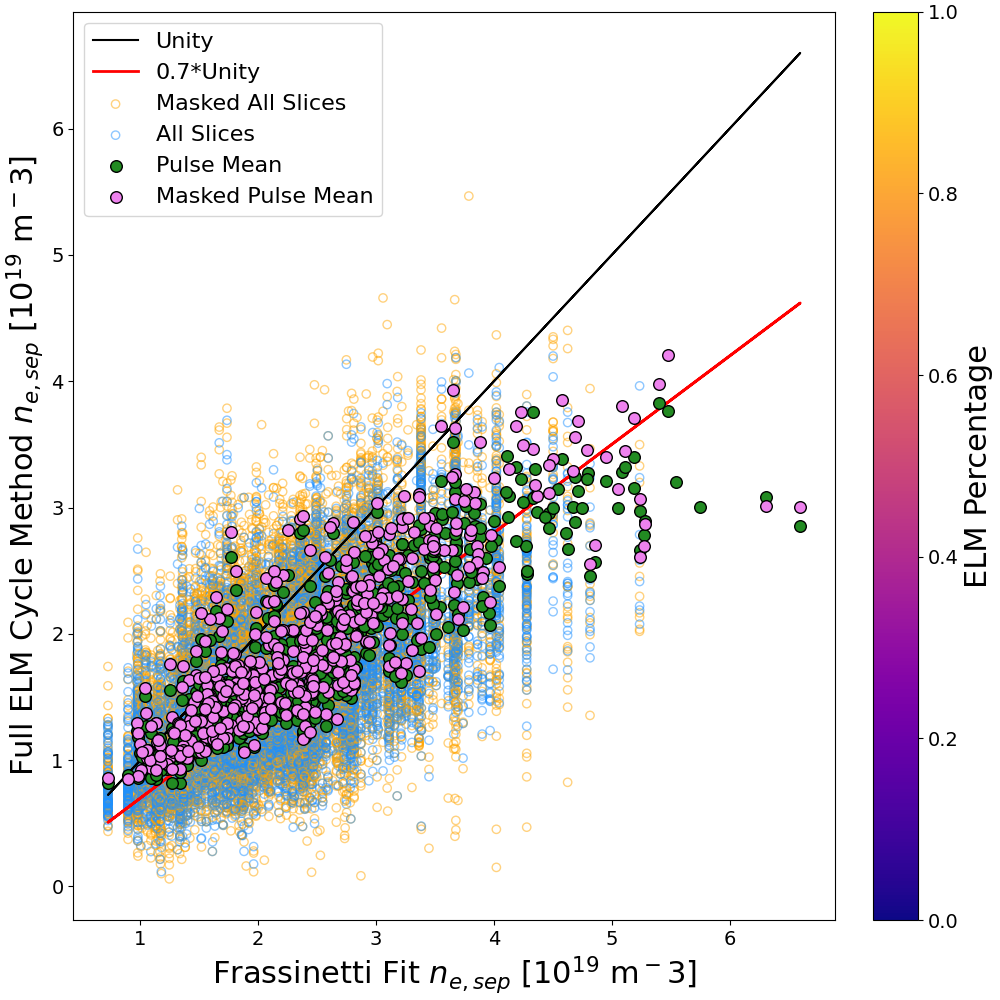

In [42]:
plt.close('all')
def corr2hex(n):
    ''' Maps a number in [0, 1] to a hex string '''
    if np.isnan(n): return plt.cm.Greys(0)
    else: 
        # print('#' + hex(int(n * 16**6))[2:].zfill(6))
        return plt.cm.plasma(n)

fig, axs = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
idx = []
for n, (pulse_masked, pulse) in enumerate(zip(train_nesep_by_pulse_masked, train_nesep_by_pulse)): 
    if n == 0: 
        label_mask = 'Masked All Slices'
        label = 'All Slices'
    else: 
        label_mask = None
        label = None
    if pulse.std() > 0.55e19 or np.isnan(pulse.std()): 
        continue
    if train_nesep_means_lorenzo[1, n] == 0.0: 
        continue
    # print(pulse, pulse_elm)
    # elm_color_map = [corr2hex(x) for x in pulse_elm]
    axs.scatter([train_nesep_means_lorenzo[1, n]]*len(pulse), 1e-19*pulse_masked, facecolors='none', edgecolor='orange', alpha=0.5, zorder=0, label=label_mask, cmap='blues')
    axs.scatter([train_nesep_means_lorenzo[1, n]]*len(pulse), 1e-19*pulse, facecolors='none', edgecolor='dodgerblue', alpha=0.5, zorder=0, label=label, cmap='blues')
    
    # axs.scatter(train_means_lorenzo[1, n], np.quantile(1e-19*pulse, 0.85), color='gold',zorder=5)

axs.scatter(train_nesep_means_lorenzo[1], 1e-19*train_nesep_means_lorenzo[0], color='forestgreen', zorder=10, edgecolor=(0, 0, 0), label='Pulse Mean', s=70)
axs.scatter(train_nesep_means_lorenzo[1], 1e-19*train_nesep_means_lorenzo[2], color='violet', zorder=10, edgecolor=(0, 0, 0), label='Masked Pulse Mean', s=70)
axs.plot(train_nesep_means_lorenzo[1], train_nesep_means_lorenzo[1], color='black', label='Unity')
axs.plot(train_nesep_means_lorenzo[1], 0.7*train_nesep_means_lorenzo[1], color='red', label='0.7*Unity', lw=2)
axs.legend()
axs.set_ylabel('Full ELM Cycle Method $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
axs.set_xlabel('Frassinetti Fit $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
plt.colorbar(cm.ScalarMappable(norm=None, cmap=plt.cm.plasma), label='ELM Percentage')
plt.show()

In [ ]:
import seaborn as sns
plt.close('all') 

final_list_neseps, final_list_elm_timings = [], []# [x for x in by_pulse for by_pulse in train_nesep_by_pulse]
for n, (pulse, pulse_elm) in enumerate(zip(train_nesep_by_pulse, train_elm_by_pulse)): 
#     nan_check = np.logical_and(np.invert(np.isnan(pulse_elm)), np.invert(np.isnan(pulse)))
    final_list_neseps.extend(pulse)
    final_list_elm_timings.extend(pulse_elm)
sns.histplot(x=final_list_neseps, y = final_list_elm_timings)
    
plt.show()

In [ ]:
fig = plt.figure()

plt.scatter(train_means_lorenzo[1], 1e-19*train_means_lorenzo[0])
plt.plot(train_means_lorenzo[1], train_means_lorenzo[1])
plt.plot(train_means_lorenzo[1], 0.7*train_means_lorenzo[1], color='red')
plt.show()

In [ ]:
model_hyperparams_physics = {'in_ch': 2, 'out_length':19,
                    'mach_latent_dim': 9, 'stoch_latent_dim': 3,
                    'beta_stoch': 1.0, 'beta_mach_unsup':  0.001,'beta_mach_sup':  0.0,
                    'alpha_mach': 1.0, 'alpha_prof': 20.0,  # 212, 306, 26, 295, 263, 336] 	[485, 499, 352, 432]
                    'start_sup_time': 1000,
                    'physics': False, 'gamma_stored_energy': 1.0, 'gamma_bpol': 1.0, 'gamma_beta': 1.0, 
                    'mp_hdims_aux': [64, 32], 'mp_hdims_cond':[64, 32], # 'mp_hdims_aux': [263, 469, 284], 'mp_hdims_cond':[20, 136, 54, 205, 154, 408], # 'mp_hdims_cond': [397, 369, 29, 113, 284], 'mp_hdims_aux': [122, 398, 463, 354, 399], 
                    'hidden_dims': [2, 4], 'loss_type': 'semi-supervised',}
model_physics = DIVAMODEL(**model_hyperparams_physics)
model_name_physics = 'modelstatedict_SECULAR_semi-supervised-cutoffLOSS_9MD_3SD_0BMUN_15.0BMSUP_5.0BS_500AM_379AP_50EP' # Helsinki desktop example
# model_name_physics = 'modelstatedict_SCHEDULER_PHYSICS_9MD_3SD_0BMUN_10.0BMSUP_1.5BS_500AM_960AP_50EP_100.0GAMMA' # Home Laptop Example
state_dict = torch.load('../Find_optimal_model/model_results/{}.pth'.format(model_name_physics))
# model_physics.load_state_dict(state_dict['model'])

# Convert things to tensors 
norms_MP, norms_D, norms_T = state_dict['MP_norms'], state_dict['D_norms'], state_dict['T_norms']
MP_norm, MP_var = norms_MP
D_norm, D_var = norms_D
T_norm, T_var = norms_T


all_masks = np.vstack((train_mask, val_mask, test_mask)) > 0
all_psis = np.vstack((train_radii, val_radii, test_radii))
all_rmids = np.vstack((train_real_space_radii, val_real_space_radii, test_real_space_radii))

# Training Tensors 

train_mp_tensors = torch.tensor(train_y).float()
val_mp_tensors = torch.tensor(val_y).float()
test_mp_tensors = torch.tensor(test_y).float()
all_mp_tensors = torch.vstack((train_mp_tensors, val_mp_tensors, test_mp_tensors))


train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)
val_mp_normalized = standardize(val_mp_tensors, MP_norm, MP_var)
test_mp_normalized = standardize(test_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X).float()
val_profiles = torch.tensor(val_X).float()
test_profiles = torch.tensor(test_X).float()
all_profiles = torch.vstack((train_profiles, val_profiles, test_profiles))

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized = normalize_profiles(train_profiles_normalized, T_norm, T_var, D_norm, D_var)

val_profiles_normalized = torch.clone(val_profiles).float()
val_profiles_normalized = normalize_profiles(val_profiles_normalized, T_norm, T_var, D_norm, D_var)

test_profiles_normalized = torch.clone(test_profiles).float()
test_profiles_normalized = normalize_profiles(test_profiles_normalized, T_norm, T_var, D_norm, D_var)


In [ ]:
def calculate_neseps_in_set_with_predictions(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_mps, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_real_pred_lorenzo = np.zeros((3, len(set_ids)))
    nesep_real_means_by_pulse, nesep_pred_means_by_pulse = [], []
    for k in iterator: 
        slice_loc_in_set = set_ids[k]
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[0]
     
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks, sample_mps = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], set_mps[slice_loc_in_set]
        
            
        pulse_real_neseps = calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000)
        
        # Get conditional preds
        conditional_profiles = conditional_inference_simple_mean((sample_profiles, _, sample_masks, _, sample_mps, _, _), model_physics)
        pulse_preds_neseps = calculate_nesep_for_pulse(conditional_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000, conditional_prediction=True)
        
        
        mean_real_pulse_nesep = pulse_real_neseps.mean()
        mean_pred_pulse_nesep = pulse_preds_neseps.mean()
        
        neseps_means_real_pred_lorenzo[:, k] = [mean_real_pulse_nesep, mean_pred_pulse_nesep, lorenzo_nesep_exp]
        
        nesep_real_means_by_pulse.append(pulse_real_neseps)
        nesep_pred_means_by_pulse.append(pulse_preds_neseps)
        
        iterator.set_description_str(str(pulse_number))
        iterator.set_postfix_str('fras{:.3}mean{:.4}pred{:.4}'.format(lorenzo_nesep_exp, 1e-19*mean_real_pulse_nesep, 1e-19*mean_pred_pulse_nesep ))
        
        
        
    return neseps_means_real_pred_lorenzo, nesep_real_means_by_pulse, nesep_pred_means_by_pulse


In [ ]:
neseps_conditional_real_lorenzo, neseps_real_by_pulse, neseps_conditional_by_pulse = calculate_neseps_in_set_with_predictions(train_pulse_idxs, train_profiles, train_uncert, train_mask, train_pulse_order, train_mp_tensors, JET_PDB)
# train_means_lorenzo, train_by_pulse = calculate_neseps_in_set(train_pulse_idxs, train_X, train_uncert, train_mask, train_pulse_order, JET_PDB)

In [ ]:
plt.close('all')
fig, axs = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
for n, (pulse_real, pulse_cond) in enumerate(zip(neseps_real_by_pulse, neseps_conditional_by_pulse)): 
    if n == 0: 
        label = 'All Slices'
    else: 
        label = None
    axs.scatter(pulse_real, pulse_cond, facecolors='none', edgecolor='dodgerblue', alpha=0.5, zorder=0, label=label)
    axs.plot(pulse_real, pulse_real, color='black')
    axs.plot(pulse_real, 1.2*pulse_real, color='black',ls='--')
    axs.plot(pulse_real, 0.8*pulse_real, color='black',ls='--')
    
axs.scatter(neseps_conditional_real_lorenzo[0], neseps_conditional_real_lorenzo[1], color='forestgreen', zorder=10, edgecolor=(0, 0, 0), label='Pulse Mean', s=70)
axs.plot(neseps_conditional_real_lorenzo[0], neseps_conditional_real_lorenzo[0], color='black', label='Unity')
axs.legend()
axs.set_xlabel('Full ELM Cycle Method $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
axs.set_ylabel('Predicted $n_{e, sep}$ [$10^{19}$ m$^-3$]',)
plt.show()

In [ ]:
line_of_sight = pd.read_csv('/home/adam/Desktop/pulse_91962_line_of_sight.dat', skiprows=4, names=['R', 'NE'], sep='  ')['R'].to_list()

  0%|          | 0/77 [00:00<?, ?it/s]

['87173/51.57' '87173/51.62' '87173/51.67' '87173/51.72' '87173/51.77'
 '87173/51.82' '87173/51.87' '87173/51.92' '87173/51.97' '87173/52.02'
 '87173/52.07' '87173/52.12' '87173/52.17' '87173/52.22' '87173/52.27'
 '87173/52.32' '87173/52.37' '87173/52.42' '87173/52.47' '87173/52.52'
 '87173/52.57' '87173/52.62' '87173/52.67' '87173/52.72' '87173/52.77'
 '87173/52.82' '87173/52.87' '87173/52.92' '87173/52.97' '87173/53.02'
 '87173/53.07' '87173/53.12' '87173/53.17' '87173/53.22' '87173/53.27'
 '87173/53.32' '87173/53.37' '87173/53.42' '87173/53.47' '87173/53.52'
 '87173/53.57' '87173/53.62' '87173/53.67' '87173/53.72' '87173/53.77'
 '87173/53.82' '87173/53.87' '87173/53.92' '87173/53.97' '87173/54.02'
 '87173/54.07' '87173/54.12' '87173/54.17' '87173/54.22' '87173/54.27'
 '87173/54.32' '87173/54.37' '87173/54.42' '87173/54.47' '87173/54.52'
 '87173/54.57' '87173/54.62' '87173/54.67' '87173/54.72' '87173/54.77'
 '87173/54.82' '87173/54.87' '87173/54.92' '87173/54.97' '87173/55.02'
 '8717

No handles with labels found to put in legend.


9.182094236034452e+18


/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  self.figure.savefig(buf, format='png', dpi='figure')


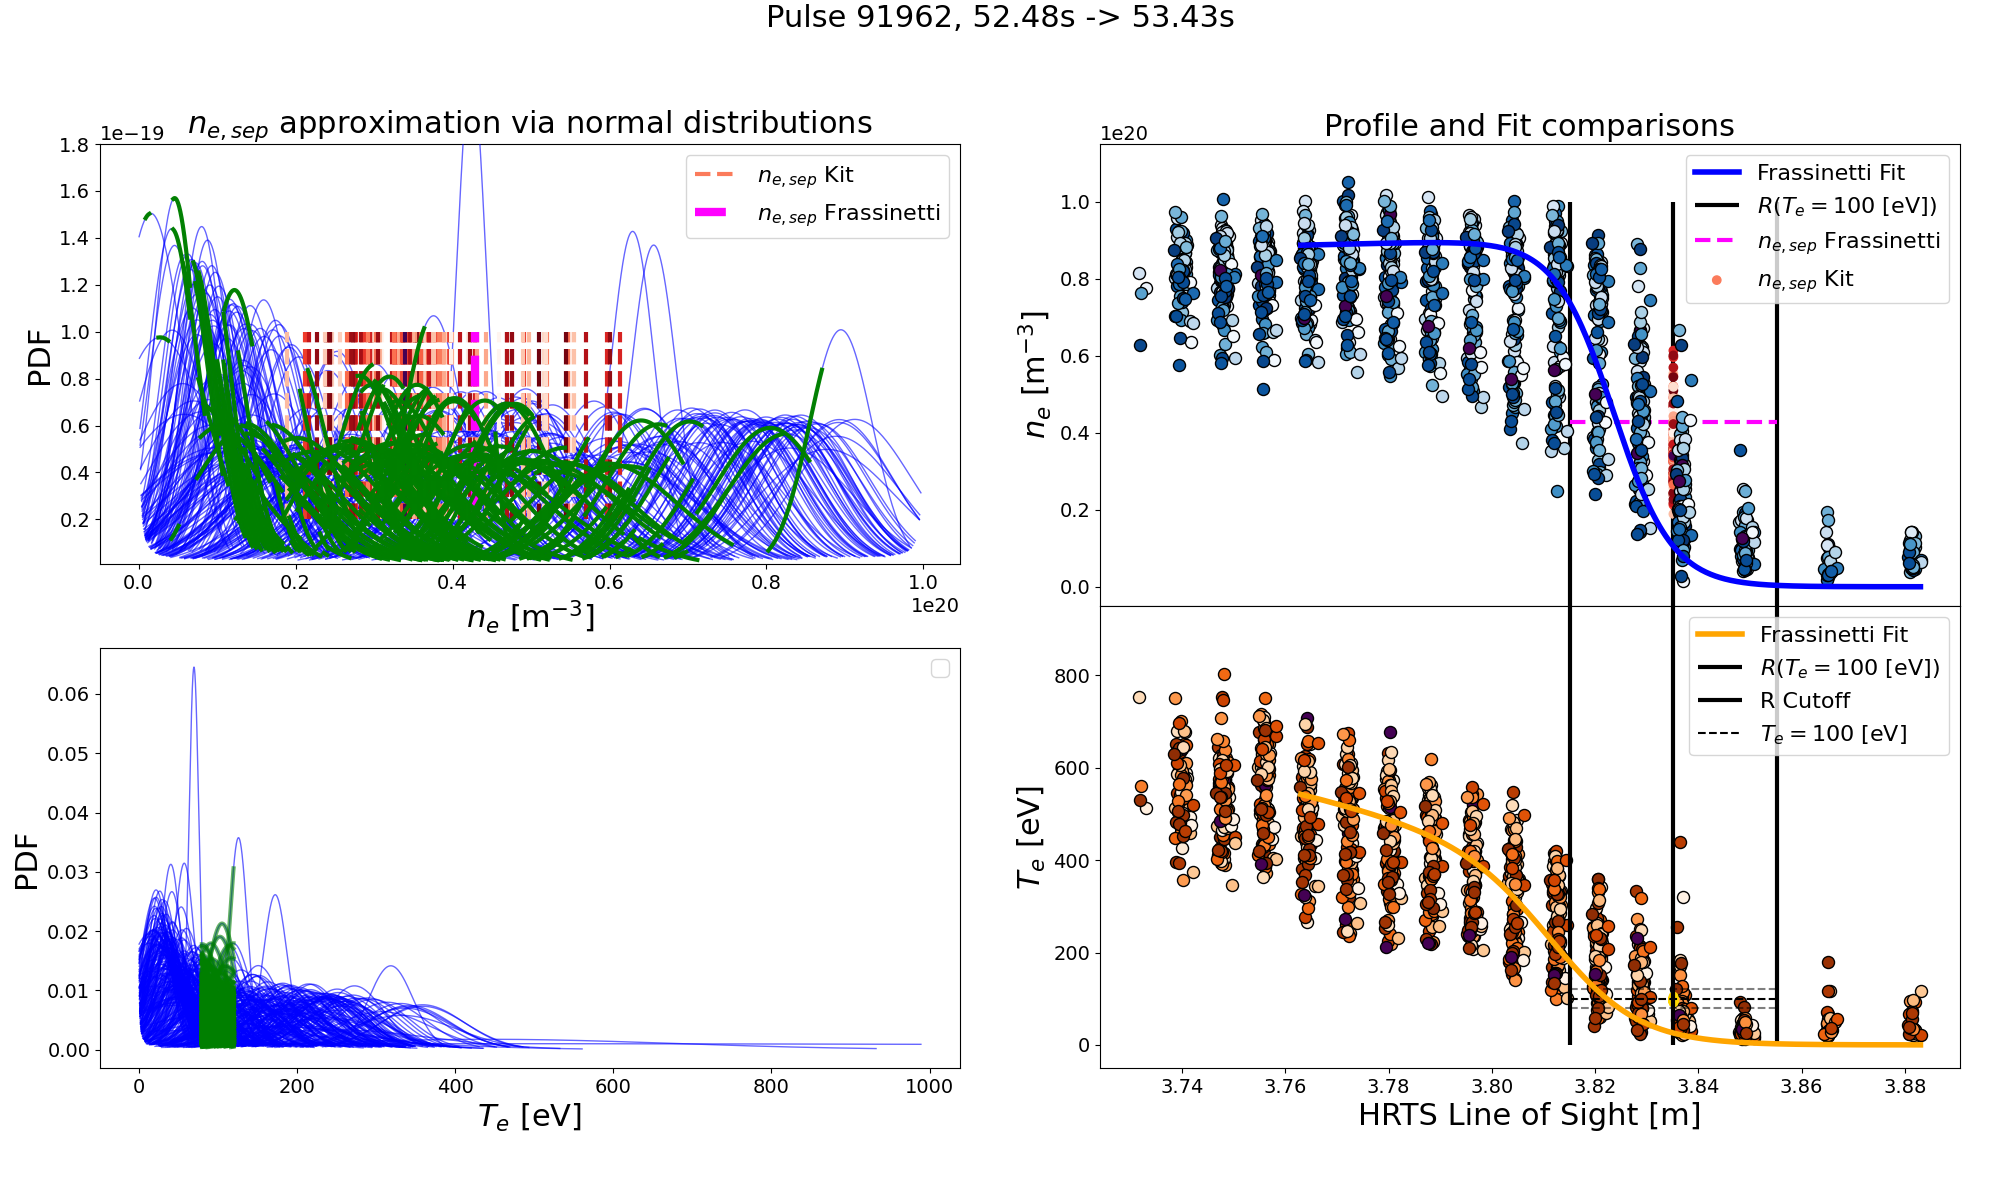

In [286]:
def corr2hex_nete(n, dtype='density'):
    ''' Maps a number in [0, 1] to a hex string '''
    
    if dtype=='density': 
        if np.isnan(n): 
            return plt.cm.viridis(0)
        else: 
            return plt.cm.Blues(n)
    elif dtype=='temperature': 

        if np.isnan(n): 
            return plt.cm.viridis(0)
        else: 
            return plt.cm.Oranges(n)
    elif dtype=='separatrix': 

        if np.isnan(n): 
            return plt.cm.viridis(0)
        else: 
            return plt.cm.Reds(n)
    
def mtanh(r_vals, h1, h0, p, w, s):
    x = (p-r_vals) / (w/2.0)
    return (h1/2.0 - h0/2.0)*((((1+s*x)*np.exp(x)) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0
    

def plot_profiles_and_mtanh(profiles, rmids, masks, uncerts, lorenzo_fit_ne, lorenzo_fit_te, lorenzo_nesep, pulse_neseps, pulse_teseps, pulse_elm_timings):
    d_profs, t_profs = profiles[:, 0, :], profiles[:, 1, :]
    dne_profs, dte_profs = uncerts[:, 0, :], uncerts[:, 1, :]

    # FIGURE SETUP
    fig = plt.figure(constrained_layout=True, figsize=(20, 12))
    
    gs1 = GridSpec(2, 1, left=0.05, right=0.48, wspace=0.05)
    ax2 = fig.add_subplot(gs1[0])
    ax1 = fig.add_subplot(gs1[1])
    
    ax1.set_xlabel('$T_e$ [eV]')
    ax2.set_xlabel('$n_e$ [m$^{-3}$]')
    ax2.set_ylabel('PDF')
    ax1.set_ylabel('PDF')
    
    gs2 = GridSpec(2, 1, left=0.55, right=0.98, hspace=0.0)
    ax3 = fig.add_subplot(gs2[0])
    ax4 = fig.add_subplot(gs2[1])
    
    ax4.set_ylabel('$T_e$ [eV]')
    ax4.set_xlabel('HRTS Line of Sight [m]')
    ax3.set_ylabel('$n_e$ [m$^{-3}$]')

    
    mtanh_radius = np.linspace(3.78, 3.9, 400)
    low_t, high_t = 80, 120
    offset = 0.022
    
    myclip_a, myclip_b = 0, 1000
    myclip_an, myclip_bn = 0, 1.0e20
    var_radius = 0.0055
    SOL_size_cm = 0.02
    
    
    pulse_neseps = []
    cutoffs = []
    teseps_cutoff = []
    
    for sl, (d_pr, t_pr, dne_pr, dte_pr, radius, mask, elm) in enumerate(zip(d_profs, t_profs, dne_profs, dte_profs, rmids, masks, pulse_elm_timings)):
        bool_mask = mask > 0
        slice_neseps, slices_rmids, slices_tseps = [], [], []
        bool_mask = np.logical_and(bool_mask, dne_pr < 1e19)
        d_prm, t_prm, dne_prm, dte_prm, rmid_prm = d_pr[bool_mask], t_pr[bool_mask], dne_pr[bool_mask], dte_pr[bool_mask], radius[bool_mask]
        
        for mea, (mu_t, var_t, mu_n, var_n, rad) in enumerate(zip(t_prm, dte_prm, d_prm, dne_prm, rmid_prm)): 
            a, b = (3.7 - rad) /var_radius, (3.9 - rad) / var_radius
            rmid_sample = np.linspace(truncnorm.ppf(0.01, a, b, rad, var_radius), truncnorm.ppf(0.99, a, b, rad, var_radius), 10000)
            a, b = (myclip_a - mu_t) / var_t, (myclip_b - mu_t) / var_t
            x_t = np.linspace(truncnorm.ppf(0.01, a, b, mu_t, var_t), truncnorm.ppf(0.99, a, b, mu_t, var_t), 10000)
            
            separatrix_loc = np.logical_and(x_t>low_t, x_t<high_t)
            x_tesep = x_t[separatrix_loc]
            
            rmid_tesep = rmid_sample[separatrix_loc]
            slices_rmids.extend(rmid_tesep)
            slices_tseps.extend(x_tesep)
        rmid_cutoff = np.mean(slices_rmids)
        teseps_cutoff.append(np.mean(slices_tseps))
        cutoffs.append(rmid_cutoff)
    
    rmid_cutoff = np.mean(cutoffs)
    print(rmid_cutoff)
    for sl, (d_pr, t_pr, dne_pr, dte_pr, radius, mask, elm) in enumerate(zip(d_profs, t_profs, dne_profs, dte_profs, rmids, masks, pulse_elm_timings)):
        bool_mask = mask > 0
        slice_neseps, slices_rmids, slices_tseps = [], [], []
        bool_mask = np.logical_and(bool_mask, dne_pr < 1e19)
        d_prm, t_prm, dne_prm, dte_prm, rmid_prm = d_pr[bool_mask], t_pr[bool_mask], dne_pr[bool_mask], dte_pr[bool_mask], radius[bool_mask]
        
        for meat, (mu_t, var_t, mu_n, var_n, rad) in enumerate(zip(t_prm, dte_prm, d_prm, dne_prm, rmid_prm)): 
            
            if meat == 0 and sl == 0: 
                label_t_sep  = '95 < $T_e$ < 105' 
            else: 
                label_t_sep = None
            if ((rad > rmid_cutoff + SOL_size_cm) or (rad < rmid_cutoff - SOL_size_cm)): 
                continue   
            
            a, b = (3.7 - rad) /var_radius, (3.9 - rad) / var_radius
            
            a, b = (myclip_a - mu_t) / var_t, (myclip_b - mu_t) / var_t
            x_t = np.linspace(truncnorm.ppf(0.01, a, b, mu_t, var_t), truncnorm.ppf(0.99, a, b, mu_t, var_t), 10000)
            
            separatrix_loc = np.logical_and(x_t>low_t, x_t<high_t)
            x_tesep = x_t[separatrix_loc]
            
            a, b = (myclip_an - mu_n) / var_n, (myclip_bn - mu_n) / var_n
            x = np.linspace(truncnorm.ppf(0.01, a, b, mu_n, var_n),

                            truncnorm.ppf(0.99, a, b, mu_n, var_n), 10000)

            x_nesep = x[separatrix_loc]
            
            a, b = (myclip_a - mu_t) / var_t, (myclip_b - mu_t) / var_t
            ax1.plot(x_t, truncnorm.pdf(x_t, a, b, mu_t, var_t),
               'b-', lw=1, alpha=0.6, zorder=10)
            ax1.plot(x_tesep, truncnorm.pdf(x_tesep, a, b, mu_t, var_t),
                'g-', lw=3, alpha=0.6, label=label_t_sep, zorder=20)
            
            a, b = (myclip_an - mu_n) / var_n, (myclip_bn - mu_n) / var_n
            ax2.plot(x, truncnorm.pdf(x, a, b, mu_n, var_n),
                   'b-', lw=1, alpha=0.6, zorder=10)
            ax2.plot(x_nesep, truncnorm.pdf(x_nesep, a, b, mu_n, var_n),
                   'g-', lw=3, alpha=0.99, zorder=20, label=label_t_sep)
            
            slice_neseps.extend(x_nesep)
            
        pulse_neseps.append(np.mean(slice_neseps))
            
        
        ax3.scatter(radius[bool_mask], d_pr[bool_mask], color=corr2hex_nete(elm), edgecolor=(0, 0, 0), zorder=20, s=75)
        ax4.scatter(radius[bool_mask], t_pr[bool_mask], color=corr2hex_nete(elm, 'temperature'), edgecolor=(0, 0, 0), zorder=0, s=75)
    
    
    lor_tsep_loc = mtanh_radius[np.argmin(abs(1e3*mtanh(mtanh_radius, *lorenzo_fit_te) - 0.1))]
    # offset = rmid_cutoff - lor_tsep_loc
    
    
    ax3.plot(mtanh_radius - offset + 0.005, 1e19*mtanh(mtanh_radius, *lorenzo_fit_ne), color='blue', lw=4, zorder=30, label='Frassinetti Fit')
    ax4.plot(mtanh_radius - offset+ 0.005, 1e3*mtanh(mtanh_radius, *lorenzo_fit_te), color='orange', lw=4, label='Frassinetti Fit')
    
    ax4.vlines(rmid_cutoff, 0, 1000, color='black', lw=3, label='$R(T_e = 100$ [eV])')
    ax3.vlines(rmid_cutoff, -1e19, 1e20, color='black', lw=3, label='$R(T_e = 100$ [eV])')
    ax4.vlines([rmid_cutoff+SOL_size_cm, rmid_cutoff-SOL_size_cm], 0, 1000, color='black', lw=3, label='R Cutoff')
    ax3.vlines([rmid_cutoff+SOL_size_cm, rmid_cutoff-SOL_size_cm], -1e19, 1e20, color='black', lw=3)
    
    
    ax4.set_ylim(-50, 950)
    ax3.set_ylim(-0.5e19, 1.15e20)
    ax2.set_ylim(0.1e-20, 1.8e-19)
    
    # ax4.hlines(pulse_teseps, 3.79, 3.82, color='red', ls='--')
    ax4.hlines(100, rmid_cutoff-SOL_size_cm, rmid_cutoff+SOL_size_cm, color='black', ls='--', label='$T_e = 100$ [eV]')
    ax4.hlines([low_t, high_t], rmid_cutoff-SOL_size_cm, rmid_cutoff+SOL_size_cm, color='black', ls='--', alpha=0.5)
    
    neseps_colors = [corr2hex_nete(x, 'separatrix') for x in pulse_elm_timings]
    ax3.hlines(lorenzo_nesep*1e19, rmid_cutoff-SOL_size_cm, rmid_cutoff+SOL_size_cm, lw=3, color='magenta', ls='--', label='$n_{e, sep}$ Frassinetti', zorder=15)
    # ax3.hlines(pulse_neseps, 3.79, 3.83, color=neseps_colors, lw=3, ls='--', label='$n_{e, sep}$ Kit', zorder=15)
    
    print(np.std(pulse_neseps))
    ax2.vlines(pulse_neseps, 2e-20, 1.0e-19, color=neseps_colors, ls='--', label='$n_{e, sep}$ Kit', zorder=15, lw=3)
    ax2.vlines(lorenzo_nesep*1e19, 2e-20, 1.0e-19, color='magenta', ls='--', label='$n_{e, sep}$ Frassinetti', zorder=15, lw=6)
    
    ax4.scatter([rmid_cutoff]*len(teseps_cutoff),teseps_cutoff,color='gold')
    ax3.scatter([rmid_cutoff]*len(pulse_neseps), pulse_neseps,color=neseps_colors, label='$n_{e, sep}$ Kit', zorder=15)
    axs= [ax1, ax2, ax3, ax4]
    for ax in axs: 
        ax.legend()
    fig.suptitle('Pulse 91962, 52.48s -> 53.43s')
    ax2.set_title('$n_{e,sep}$ approximation via normal distributions')
    ax3.set_title('Profile and Fit comparisons')
    # plt.savefig('./pulse_91962_nesep_comparison.png')
    plt.show()
    pass 
def look_at_high_nesep(set_ids, set_profiles, set_uncerts, set_masks, set_shot_numbers_by_slice, set_rmids, set_time_pulse_ids, set_elm_timings_by_pulse, pedestal_database): 
    iterator = tqdm(range(len(set_ids)))
    
    neseps_means_real_pred_lorenzo = np.zeros((3, len(set_ids)))
    nesep_real_means_by_pulse, nesep_pred_means_by_pulse = [], []
    for k in iterator: 
        slice_loc_in_set = set_ids[k]
        pulse_number = np.array(set_shot_numbers_by_slice)[set_ids[k]][0]
        
        if pulse_number != 87173: 
            continue
        
        if pulse_number in [86644, 96922]: 
            index_to_take_from = 1
        else: 
            index_to_take_from = 0
            
        print(np.array(set_time_pulse_ids)[slice_loc_in_set])
        
        JPDB_pulse = pedestal_database[pedestal_database['shot'] == pulse_number]
        print(len(JPDB_pulse))
        # print((JPDB_pulse[['t1', 't2', 'nepedheight10^19(m^-3)']]))
        lorenzo_nesep  = JPDB_pulse[['neseparatrixfromexpdata10^19(m^-3)', 'neseparatrixfromfit10^19(m^-3)']].values[index_to_take_from]
        # print(lorenzo_nesep)
        lorenzo_fit_ne = np.array([JPDB_pulse['nepedheight10^19(m^-3)'].values[index_to_take_from], 0.0,  JPDB_pulse['nepositionRmid(m)'].values[index_to_take_from],0.01*JPDB_pulse['NepedestalwidthRmid(cm)'].values[index_to_take_from],JPDB_pulse['neinnerslope'].values[index_to_take_from], ])
        lorenzo_fit_te = np.array([JPDB_pulse['Tepedheight(keV)'].values[index_to_take_from], 0.0,  JPDB_pulse['TepositionRmid(m)'].values[index_to_take_from],0.01*JPDB_pulse['TepedestalwidthRmid(cm)'].values[index_to_take_from],JPDB_pulse['Teinnerslope'].values[index_to_take_from], ])
        
        lorenzo_nesep_exp, lorenzo_nesep_fit = lorenzo_nesep
    
        sample_profiles, sample_uncerts, sample_masks, sample_rmids = set_profiles[slice_loc_in_set], set_uncerts[slice_loc_in_set], set_masks[slice_loc_in_set], set_rmids[slice_loc_in_set]
        
        sample_elm_timings = set_elm_timings_by_pulse[slice_loc_in_set]
        print(sample_elm_timings)
        pulse_neseps, pulse_teseps = 0.0, 0.0# calculate_nesep_for_pulse(sample_profiles, sample_uncerts, sample_masks, lbound_n = 0, ubound_n = 0.5e21, lbound_t=0, ubound_t=2000)
        plot_profiles_and_mtanh(sample_profiles, sample_rmids, sample_masks, sample_uncerts, lorenzo_fit_ne, lorenzo_fit_te, lorenzo_nesep_fit, pulse_neseps, pulse_teseps, sample_elm_timings)
                
        iterator.set_description_str(str(pulse_number))
        
        
        
    return None
plt.close('all')
look_at_high_nesep(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order, test_real_space_radii, test_ids, test_elm_timings, JET_PDB)
# look_at_high_nesep(test_pulse_idxs, test_X, test_uncert, test_mask, test_pulse_order, test_real_space_radii, test_ids, test_elm_timings, JET_PDB)

In [ ]:
def conditional_inference_simple_mean(PULSE, model=None, norms=(None, None, None, None)):
    D_norm, D_var, T_norm,T_var = norms
    X, PSI, MASK, ID, MPS, _, UNCERT = PULSE
    X[:, 0] = standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = standardize(X[:, 1], T_norm, T_var)
    MPS = standardize(MPS, MP_norm, MP_var)
    with torch.no_grad():         
        cond_mu, cond_var =  model.p_zmachx(MPS)
        z_mach = model.reparameterize(cond_mu, cond_var)
        mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(X)
        z_stoch = mu_stoch
        z_mach = cond_mu
        z_conditional = torch.cat((z_stoch, z_mach), 1)
        out_profs_cond = model.p_yhatz(z_conditional)
    out_profs_cond[:, 0] = de_standardize(out_profs_cond[:, 0], D_norm, D_var)
    out_profs_cond[:, 1] = de_standardize(out_profs_cond[:, 1], T_norm, T_var)
    MPS = de_standardize(MPS, MP_norm, MP_var)
    X[:, 0] = de_standardize(X[:, 0], D_norm, D_var)
    X[:, 1] = de_standardize(X[:, 1], T_norm, T_var)
    return out_profs_cond
from matplotlib.gridspec import GridSpec


In [ ]:

gc

In [ ]:
plt.close('all')

In [ ]:
high_nesep = PULSE_DF_SANDBOX[PULSE_DF_SANDBOX['shot'] == 91962]
high_nesep[['dda', 't1', 't2']]

In [ ]:
PULSE_DF_SANDBOX[['shot', 'dda']]
dda_dict = {'shot': [], 'uid': [], 'dda': []}
for index, row in PULSE_DF_SANDBOX.iterrows(): 

    shot, name = row['shot'], row['dda']
    dda, uid = name.split('/')
    dda_dict['shot'].append(shot)
    dda_dict['dda'].append(dda)
    dda_dict['uid'].append(uid)
    

In [ ]:
with open('../../data/raw/elm_timing_locs_data_SANDBOX_NO_VARIAITONS.pickle', 'wb') as file:
    pickle.dump(dda_dict, file)